In [1]:
#!pip install gsw -q

# Dask start

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37281")

# Import

In [3]:
import sys
sys.path.insert(1, '..')

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import gcm_filters
from dask import compute
import xgcm
import xesmf as xe
import os

In [5]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [6]:
#%matplotlib widget
%matplotlib inline

# Load data

Choose cases

In [7]:
data=[dict() for i in range(6)]

In [8]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR sum'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL wint'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL sum'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED wint'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED sum'})

In [9]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [10]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,1),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [11]:
chunk_dict = {'x' : -1, 'y' : -1, 'time_counter' : 5, 'deptht' : 20, 'depthu' : 20, 'depthv' : 20}

In [12]:
%%time
for i in range(len(data)) :
    current_set = cat.eNATL60(region=data[i]['region'],datatype='interior_daily', season=data[i]['season']).to_dask()
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set = current_set.chunk(chunk_dict)
    data[i]['HR'] = current_set

CPU times: user 2.65 s, sys: 219 ms, total: 2.87 s
Wall time: 5.64 s


In [13]:
data[0]['HR']

<xarray.Dataset>
Dimensions:       (y: 762, x: 610, deptht: 107, depthu: 107, depthv: 107,
                   depthw: 107, time_counter: 88)
Coordinates: (12/18)
    depth         (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * depthu        (depthu) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * depthv        (depthv) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * depthw        (depthw) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
    e1f           (y, x) float64 dask.array<chunksize=(762, 610), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(762, 610), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-29
Dimensions without coordinates: y, x
Data variables: (12/13)
    e3t_0         (deptht, y, x) float64 dask.array<chunksize=(20, 762, 610), meta=np.ndarray>
    e3u_0         (depthu, y, x) float64 dask.array<chunksize=(20, 762, 610), meta=np.ndarray>
    e3v_0         (depthv, y, x) float64 dask.array<chunksize=(20, 762, 610), meta=np.ndarray>
    e3w_0         (depthw, y, x) float64 dask.array<chunksize=(107, 762, 610), meta=np.ndarray>
    fmask         (deptht, y, x) int8 dask.array<chunksize=(20, 762, 610), meta=np.ndarray>
    tmask         (deptht, y, x) int8 dask.array<chunksize=(20, 762, 610), meta=np.ndarray>
    ...            ...
    vmask         (depthv, y, x) int8 dask.array<chunksize=(20, 762, 610), meta=np.ndarray>
    vomecrty      (time_counter, depthv, y, x) float32 dask.array<chunksize=(5, 20, 762, 610), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(5, 20, 762, 610), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(5, 20, 762, 610), meta=np.ndarray>
    vovecrtz      (time_counter, depthw, y, x) float32 dask.array<chunksize=(5, 107, 762, 610), meta=np.ndarray>
    vozocrtx      (time_counter, depthu, y, x) float32 dask.array<chunksize=(5, 20, 762, 610), meta=np.ndarray>

In [14]:
print(data[0]['HR'].nbytes / 1e9, "GiB")

89.364436336 GiB


# Grid metrics

In [15]:
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v'], # Y distances
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
    ('X', 'Y',): ['area'] # Areas 
}

In [16]:
chunk_dict = {'x_c' : -1, 'y_c' : -1, 'x_r' : -1, 'y_r' : -1, \
              't' : 5, 'z_c' : 7, 'z_l' : 7}

Rename and arrange the coordinates to make data suitable for xgcm and xESMF regridding :

In [18]:
%%time
for data_entity in data :
    current_set = data_entity['HR']
    ds = xr.Dataset({},
                   coords={"x_c": np.arange(len(current_set['x'])),\
                           "y_c": np.arange(len(current_set['y'])) ,\
                           "x_r": np.arange(0.5,0.5+len(current_set['x']),1.),\
                           "y_r": np.arange(0.5,0.5+len(current_set['y']),1.),\
                           "z_c": current_set['deptht'].values,\
                           "z_l": current_set['depthw'].values,\
                           "t" : current_set['time_counter'].values
                           # "z_c": np.arange(len(current_set['deptht'])),\
                           # "z_f": np.arange(0.5,0.5+len(current_set['deptht']),1.),\
                          })
    ds.coords['e1t'] = xr.DataArray(current_set.coords['e1t'].values, dims=['y_c', 'x_c'])
    ds.coords['e2t'] = xr.DataArray(current_set.coords['e2t'].values, dims=['y_c', 'x_c'])
    ds.coords['e3t'] = xr.DataArray(current_set['e3t_0'].values, dims=['z_c', 'y_c', 'x_c'])
    ds.coords['tmask'] = xr.DataArray(current_set['tmask'].values, dims=['z_c', 'y_c', 'x_c'])

    ds.coords['e1u'] = xr.DataArray(current_set.coords['e1u'].values, dims=['y_c', 'x_r'])
    ds.coords['e2u'] = xr.DataArray(current_set.coords['e2u'].values, dims=['y_c', 'x_r'])
    ds.coords['e3u'] = xr.DataArray(current_set['e3u_0'].values, dims=['z_c', 'y_c', 'x_r'])
    ds.coords['umask'] = xr.DataArray(current_set['umask'].values, dims=['z_c', 'y_c', 'x_r'])

    ds.coords['e1v'] = xr.DataArray(current_set.coords['e1v'].values, dims=['y_r', 'x_c'])
    ds.coords['e2v'] = xr.DataArray(current_set.coords['e2v'].values, dims=['y_r', 'x_c'])
    ds.coords['e3v'] = xr.DataArray(current_set['e3v_0'].values, dims=['z_c', 'y_r', 'x_c'])
    ds.coords['vmask'] = xr.DataArray(current_set['vmask'].values, dims=['z_c', 'y_r', 'x_c'])

    ds.coords['e1f'] = xr.DataArray(current_set.coords['e1f'].values, dims=['y_r', 'x_r'])
    ds.coords['e2f'] = xr.DataArray(current_set.coords['e2f'].values, dims=['y_r', 'x_r'])
    #ds.coords['e3f'] = xr.DataArray(current_set['e3v_0'].values, dims=['z_c', 'y_r', 'x_r'])
    ds.coords['fmask'] = xr.DataArray(current_set['fmask'].values, dims=['z_c', 'y_r', 'x_r'])

    ds.coords['e3w'] = xr.DataArray(current_set['e3w_0'].values, dims=['z_l', 'y_c', 'x_c'])

    ds.coords['depth'] = xr.DataArray(current_set['depth'].values, dims=['y_c', 'x_c'])
    ds.coords['lat'] = xr.DataArray(current_set['lat'].values, dims=['y_c', 'x_c'])
    ds.coords['lon'] = xr.DataArray(current_set['lon'].values, dims=['y_c', 'x_c'])
    
    ds = ds.chunk(chunk_dict)
    
    ds['vosaline'] = current_set['vosaline'].\
    reset_coords(names=['depth','e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'], \
                 drop=True).\
    reindex(deptht = ds.z_c.values, y = ds.y_c.values, x = ds.x_c.values, method='bfill').\
    rename(deptht = 'z_c', y='y_c', x='x_c', time_counter='t')
    ds['votemper'] = current_set['votemper'].\
    reset_coords(names=['depth','e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'], \
                 drop=True).\
    reindex(deptht = ds.z_c.values, y = ds.y_c.values, x = ds.x_c.values, method='bfill').\
    rename(deptht = 'z_c', y='y_c', x='x_c', time_counter='t')
    ds.coords['area'] = ds['e1t']*ds['e2t']
    
    # Preparation of corner coordinates for the regridder
    ds = xgcm.autogenerate.generate_grid_ds(ds, axes_dims_dict={'X' : 'x_c', 'Y' : 'y_c'}, \
                                                axes_coords_dict={'X' : 'lon', 'Y' : 'lat'}, position=('center', 'outer'))
    ds = ds.rename({'x_c_outer': 'x_b','y_c_outer': 'y_b'})
    
    data_entity['HR_grid'] = xgcm.Grid(ds, metrics=metrics, periodic=False, \
                         coords={'X' : {'center' : 'x_c', 'right' : 'x_r', 'outer' : 'x_b'}, \
                                'Y' : {'center' : 'y_c', 'right' : 'y_r', 'outer' : 'y_b'},
                                'Z' : {'center' : 'z_c', 'left' : 'z_l'}})
    ds.coords['lon_b'] = data_entity['HR_grid'].interp(da=ds['lon_outer'].load(), axis='Y', to='outer',boundary='extend')
    ds.coords['lat_b'] = data_entity['HR_grid'].interp(da=ds['lat_outer'].load(), axis='X', to='outer',boundary='extend')
    
    ds = ds.chunk(chunk_dict | {'x_b' : -1, 'y_b' : -1})
    
    ds.coords['depth_c'] = ds.z_c
    ds.coords['depth_l'] = ds.z_l
    
    data_entity['HR_new_coords'] = ds

CPU times: user 28.9 s, sys: 20.5 s, total: 49.4 s
Wall time: 1min 40s


# Computation of variables before coarsening

In [19]:
g = 9.80665 
rho_0 = 1023.6

In [20]:
def vars_before_coars(input_ds, grid) :
    ds = input_ds
    # Compute sea pressure
    # NOT to forget minus in front of z
    ds['pressure'] = xr.apply_ufunc(gsw.conversions.p_from_z, -ds.depth_c, ds.lat, dask='parallelized')
    
    # Compute density
    ds['rho_true'] = xr.apply_ufunc(gsw.density.rho, ds.vosaline, ds.votemper, ds.pressure, dask='parallelized')
    ds['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, ds.vosaline, ds.votemper, dask='parallelized')
    
    # Squares for computing the subgrid variance
    ds['rho_true_sqr'] = ds['rho_true']**2
    ds['sigma0_true_sqr'] = ds['sigma0_true']**2
    ds['votemper_sqr'] = ds['votemper']**2
    ds['vosaline_sqr'] = ds['vosaline']**2
    
    ds = ds.chunk(chunk_dict | {'x_b' : -1, 'y_b' : -1})
    return ds

# Computation of variables after coarsening

In [21]:
def vars_after_coars(input_ds, grid) :
    ds = input_ds
    
    ds['pressure'] = xr.apply_ufunc(gsw.conversions.p_from_z, -ds.depth_c, ds.lat, dask='parallelized')
    # Compute density
    ds['rho_model'] = xr.apply_ufunc(gsw.density.rho, ds.vosaline, ds.votemper, ds.pressure, dask='parallelized')
    ds['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, ds.vosaline, ds.votemper, dask='parallelized')
    
    # density error
    ds['rho_delta'] = ds['rho_true'] - ds['rho_model']
    ds['sigma0_delta'] = ds['sigma0_true'] - ds['sigma0_model']  
    
    # subgrid variance
    for var in ['votemper', 'vosaline'] :
        ds[var+'_var'] = ds[var+'_sqr'] - ds[var]**2

    # vertical derivatives
    ds['dZ_rho_model'] = data_entity['LR_grid'].derivative(ds.rho_model, axis='Z', boundary='extend')
        
    # horizontal derivatives
    for axis in ['X', 'Y'] :
        for variable in ['votemper', 'vosaline', 'sigma0_model', 'rho_model', 'sigma0_delta', 'rho_delta', 'votemper_var', 'vosaline_var'] :
            ds['d'+axis+'_'+variable] = grid.derivative(ds[variable], axis=axis, boundary='extend')  
        ds['d'+axis+'_p'] = g/rho_0*grid.cumint(grid.interp(ds['d'+axis+'_rho_model'], axis=[axis, 'Z'], boundary='extend'), axis='Z')
        ds['d'+axis+'_p_error'] = g/rho_0*grid.cumint(grid.interp(ds['d'+axis+'_rho_delta'], axis=[axis, 'Z'], boundary='extend'), axis='Z')
    for variable in ['votemper', 'vosaline'] :
        for axis in ['X', 'Y'] :
            ds['diff_'+axis+'_'+variable] = grid.diff(ds[variable], axis=axis, boundary='extend')
        ds['diff_'+variable+'_sqr'] = grid.interp(ds['diff_X_'+variable]**2, 'X') + grid.interp(ds['diff_Y_'+variable]**2, 'Y')    

    # second derivatives of EOS
    temp_array = xr.apply_ufunc(gsw.rho_second_derivatives, ds.vosaline, ds.votemper, \
                                ds.pressure.expand_dims(dim={"t": ds.t.values}, axis=0), \
                            input_core_dims = [('t', 'z_c', 'y_c', 'x_c') for i in range(3)],\
                           output_core_dims = [('t', 'z_c', 'y_c', 'x_c') for i in range(5)],\
                           dask='parallelized', dask_gufunc_kwargs=dict({'allow_rechunk' : True})) 
    ds['rho_sa_sa'] = xr.DataArray(temp_array[0], dims=['t', 'z_c', 'y_c', 'x_c'])
    ds['rho_sa_ct'] = xr.DataArray(temp_array[1], dims=['t', 'z_c', 'y_c', 'x_c'])
    ds['rho_ct_ct'] = xr.DataArray(temp_array[2], dims=['t', 'z_c', 'y_c', 'x_c'])
    ds['rho_sa_p'] = xr.DataArray(temp_array[3], dims=['t', 'z_c', 'y_c', 'x_c'])
    ds['rho_ct_p'] = xr.DataArray(temp_array[4], dims=['t', 'z_c', 'y_c', 'x_c'])
    del temp_array
    
    # predictors 
    ds['predictor_T'] = 0.5*ds['rho_ct_ct']*ds['diff_votemper_sqr']
    ds['predictor_S'] = 0.5*ds['rho_sa_sa']*ds['diff_vosaline_sqr']
    ds['predictor_TS'] = 0.5*ds['rho_sa_ct']*np.sqrt(ds['diff_vosaline_sqr']*ds['diff_votemper_sqr'])
    return ds

# Coasening

In [22]:
grid_LR = xr.open_dataset('../global_eORCA025_mesh3D.nc', chunks='auto')
grid_LR.coords['area'] = grid_LR['e1t']*grid_LR['e2t']

Select level for the mask:

In [23]:
max_depth_HR = data[0]['HR_new_coords'].depth_c[-1].values
print(max_depth_HR)

1002.37274


In [24]:
grid_LR_cut_z = grid_LR.where(grid_LR.depth_c>(-data[0]['HR_new_coords'].depth_c.max().values),drop=True).z_c

In [25]:
mask_level_index_LR = grid_LR_cut_z.shape[0]

In [26]:
mask_depth_LR = grid_LR.depth_c[mask_level_index_LR].values
print(mask_depth_LR)

-1045.8543018703663


In [27]:
grid_LR_1level = grid_LR.isel(z_c=0, drop=True)
#grid_LR_1level = grid_LR

In [28]:
grid_LR_1level

<xarray.Dataset>
Dimensions:  (y: 1205, x: 1440, x_b: 1441, y_b: 1206)
Coordinates: (12/13)
  * y        (y) int64 1 2 3 4 5 6 7 8 ... 1199 1200 1201 1202 1203 1204 1205
  * x        (x) int64 1 2 3 4 5 6 7 8 ... 1434 1435 1436 1437 1438 1439 1440
    lat      (y, x) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    e1t      (y, x) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    e2t      (y, x) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    ...       ...
    mask     (y, x) int8 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
  * x_b      (x_b) float64 0.5 1.5 2.5 3.5 ... 1.438e+03 1.44e+03 1.44e+03
  * y_b      (y_b) float64 0.5 1.5 2.5 3.5 ... 1.204e+03 1.204e+03 1.206e+03
    lon_b    (y_b, x_b) float64 dask.array<chunksize=(1206, 1441), meta=np.ndarray>
    lat_b    (y_b, x_b) float64 dask.array<chunksize=(1206, 1441), meta=np.ndarray>
    area     (y, x) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
Data variables:
    *empty*

In [29]:
SCRATCH_BUCKET = os.environ['SCRATCH_BUCKET'] 

## Test

In [30]:
# test = data[0]

# test = vars_before_coars(data[0]['HR_new_coords'], data[0]['HR_grid'])

# test.coords['mask'] = test.tmask.isel(z_c=-1, drop=True)

# test = test.drop_dims(['x_r', 'y_r']).drop_vars(['lon_outer', 'lat_outer', 'e1t', 'e2t', 'pressure'], errors='ignore')

# test = test.rename({'x_c' : 'x', 'y_c' : 'y'})

# test = test.where(test.mask)

# # to take a part of the global grid corresponding to the data cut
# selection = grid_LR_1level.lon.where((grid_LR_1level.lon>=test.lon.min().values) & (grid_LR_1level.lon<=test.lon.max().values) &\
#                               (grid_LR_1level.lat>=test.lat.min().values) & (grid_LR_1level.lat<=test.lat.max().values), drop=True)
# selected_x = list(selection.x.values)
# selected_y = list(selection.y.values)
# sel_grid_LR = grid_LR_1level.isel(x=selected_x[0:-1], x_b=selected_x, \
#                            y=selected_y[0:-1], y_b=selected_y)

# #sel_grid_LR = sel_grid_LR.drop_dims(['x_r', 'y_r'])

# # reinit x and y arrays
# sel_grid_LR.coords['x'] = np.arange(1,len(selected_x))
# sel_grid_LR.coords['y'] = np.arange(1,len(selected_y))
# sel_grid_LR.coords['x_b'] = np.arange(1,len(selected_x)+1)-0.5
# sel_grid_LR.coords['y_b'] = np.arange(1,len(selected_y)+1)-0.5
# sel_grid_LR.coords['x_r'] = np.arange(1,len(selected_x))+0.5
# sel_grid_LR.coords['y_r'] = np.arange(1,len(selected_y))+0.5

# %%time
# # create regridder, i.e. compute weights
# regridder = xe.Regridder(test.isel(z_c=-1, z_l=-1, drop=True), sel_grid_LR, method="conservative_normed")

# %%time
# test_LR = regridder(test)

# %%time
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,3), constrained_layout=True)
# variable='votemper'
# #test_LR[variable].median(['x', 'y', 't']).plot(ax=ax, y='z_c', marker='.', color='k')

# test_LR[variable].isel({'x' : 20, 'y':20, 't':0}).plot(ax=ax, y='z_c', color='k', ls='-',  marker='.', lw=0.5)
# ax.invert_yaxis()
# ax.grid(True)
# ax.set(ylabel='level')
# plt.show()

## Perform on all data

In [31]:
%%time
for i in range(len(data)) :
    data_entity = data[i]
    
    ds = vars_before_coars(data_entity['HR_new_coords'], data_entity['HR_grid'])
    # select unique mask for all levels, corresponding to the mask at max depth (1000 m)
    ds.coords['mask'] = ds.tmask.isel(z_c=-1, drop=True)
    ds['var_e3t'], ds['var_e3w'] = [data_entity['HR_new_coords'].coords[item] for item in ['e3t', 'e3w']]
    ds = ds.drop_dims(['x_r', 'y_r']).drop_vars(['lon_outer', 'lat_outer', 'e1t', 'e2t', 'pressure'], errors='ignore')
    ds = ds.rename({'x_c' : 'x', 'y_c' : 'y'})
    # apply mask
    ds = ds.where(ds.mask)
    
    # to take a part of the global grid corresponding to the data cut
    selection = grid_LR_1level.lon.where((grid_LR_1level.lon>=ds.lon.min().values) & (grid_LR_1level.lon<=ds.lon.max().values) &\
                                  (grid_LR_1level.lat>=ds.lat.min().values) & (grid_LR_1level.lat<=ds.lat.max().values), drop=True)
    selected_x = list(selection.x.values)
    selected_y = list(selection.y.values)
    sel_grid_LR = grid_LR_1level.isel(x=selected_x[0:-1], x_b=selected_x, \
                               y=selected_y[0:-1], y_b=selected_y)
    
    # reinit x and y arrays
    sel_grid_LR.coords['x'] = np.arange(1,len(selected_x))
    sel_grid_LR.coords['y'] = np.arange(1,len(selected_y))
    sel_grid_LR.coords['x_b'] = np.arange(1,len(selected_x)+1)-0.5
    sel_grid_LR.coords['y_b'] = np.arange(1,len(selected_y)+1)-0.5
    sel_grid_LR.coords['x_r'] = np.arange(1,len(selected_x))+0.5
    sel_grid_LR.coords['y_r'] = np.arange(1,len(selected_y))+0.5
    
    # create regridder, i.e. compute weights
    # TODO : save weights and reuse them (can accelerate pre-treatment)
    regridder = xe.Regridder(ds.isel(z_c=-1, z_l=-1, drop=True), sel_grid_LR, method="conservative_normed")
    
    # perform coarsening
    data_entity['LR'] = regridder(ds)
    data_entity['LR'] = data_entity['LR'].drop_dims(['x_b', 'y_b'])
    data_entity['LR'].coords['e3t'], data_entity['LR'].coords['e3w'] = [data_entity['LR'][item] for item in ['var_e3t', 'var_e3w']]
    data_entity['LR'] = xr.merge([sel_grid_LR.drop_dims(['x_b', 'y_b']), \
                                  data_entity['LR'].drop_vars(['var_e3t', 'var_e3w'])], compat='override')
    data_entity['LR'] = (data_entity['LR'].rename({'x': 'x_c', 'y' : 'y_c'})).persist()
    
    #create grid for xgcm
    metrics_LR = {
        ('X',): ['e1t'], # X distances
        ('Y',): ['e2t'], # Y distances
        ('Z',): ['e3t', 'e3w'], # Z distances
        ('X', 'Y',): ['area'] }
    data_entity['LR_grid'] = xgcm.Grid(data_entity['LR'], metrics=metrics_LR, periodic=False, \
                         coords={'X' : {'center' : 'x_c', 'right' : 'x_r'}, \
                                'Y' : {'center' : 'y_c', 'right' : 'y_r'},
                                'Z' : {'center' : 'z_c', 'left' : 'z_l'}})
    # Calculate LR variables
    new_LR = vars_after_coars(data_entity['LR'], data_entity['LR_grid'])
    data_entity['LR'] = new_LR
    
    # write on disk
    #new_LR.to_netcdf("/tmp/dataLR"+str(i)+".nc")
    new_LR.to_zarr(store=f'{SCRATCH_BUCKET}/data3D_'+str(i)+'.zarr', mode='w')  # write data
    #client.cancel(data_entity['LR'], new_LR)  
    print('Finished writing dataset '+str(i))

Finished writing dataset 0
Finished writing dataset 1
Finished writing dataset 2
Finished writing dataset 3
Finished writing dataset 4
Finished writing dataset 5
CPU times: user 4min 56s, sys: 12.7 s, total: 5min 9s
Wall time: 1h 2min 17s


In [32]:
print(data[0]['LR'].nbytes / 1e6, "MiB")

6776.652603 MiB


# Plot

CPU times: user 2.38 s, sys: 101 ms, total: 2.48 s
Wall time: 21.9 s


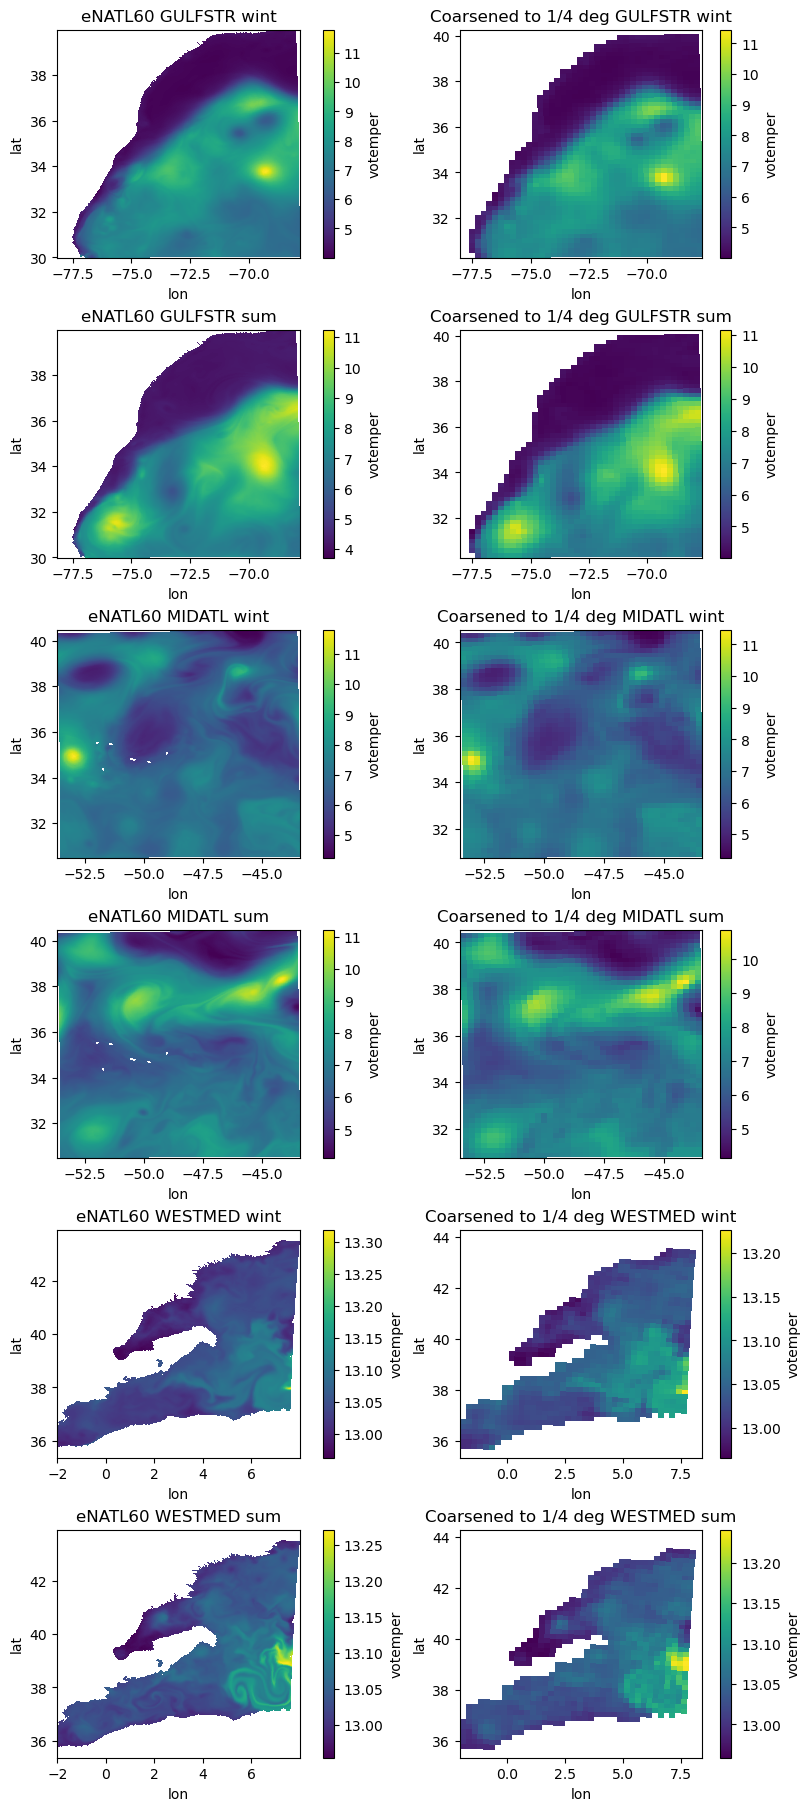

In [33]:
%%time
fig, ax = plt.subplots(ncols=2, nrows=len(data), figsize=(8,3.0*len(data)), constrained_layout=True)
for row, data_entity in enumerate(data) :
    data_entity['HR_new_coords'].votemper.isel(z_c=-1, t=0).plot(ax=ax[row,0], x='lon', y='lat')
    data_entity['LR'].votemper.isel(z_c=-1, t=0).plot(ax=ax[row,1], x='lon', y='lat')
    ax[row,0].set(title='eNATL60 '+data_entity['label'])
    ax[row,1].set(title='Coarsened to 1/4 deg '+data_entity['label'])

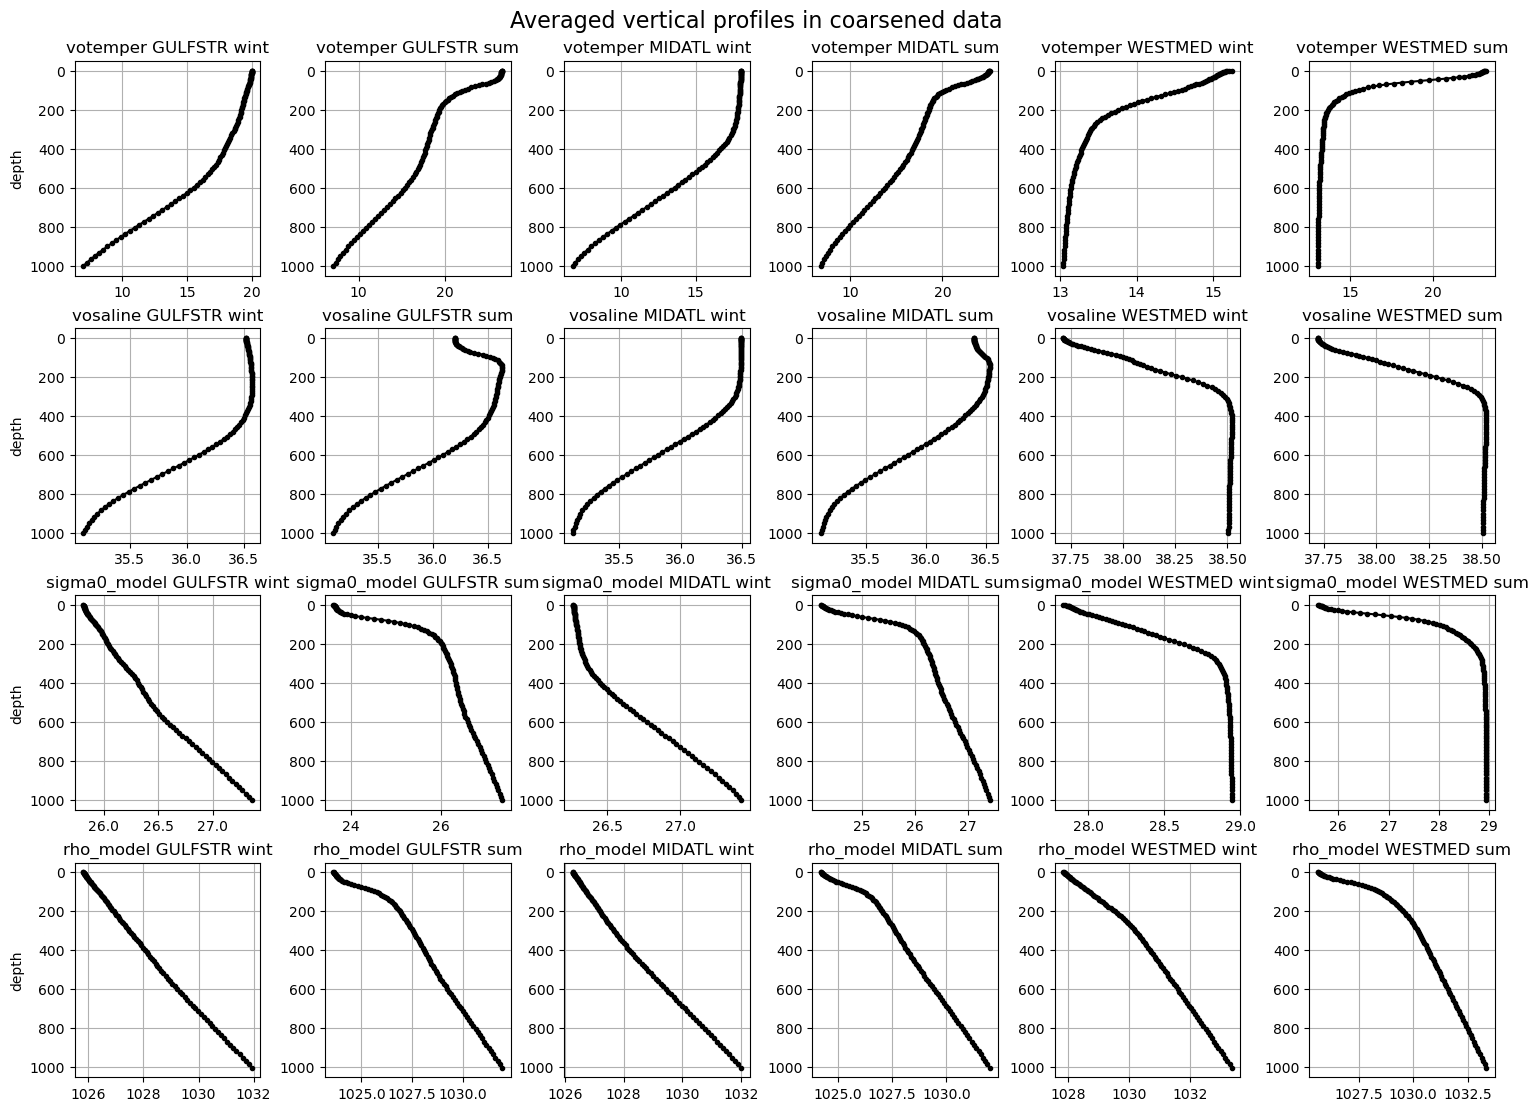

CPU times: user 5.88 s, sys: 73.1 ms, total: 5.95 s
Wall time: 39 s


In [35]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=4, figsize=(15,11), constrained_layout=True)
fig.suptitle('Averaged vertical profiles in coarsened data', fontsize=16)
for row, variable in enumerate(['votemper', 'vosaline', 'sigma0_model', 'rho_model']) :
    for col in range(len(data)) :
        data[col]['LR'][variable].median(['x_c', 'y_c', 't']).plot(ax=ax[row,col], y='depth_c', \
                                                                   label=data[col]['label'], marker='.', color='k')
        ax[row,col].set(title=variable+' '+data[col]['label'], xlabel='', ylabel='', xscale='linear', yscale='linear')
        ax[row,col].grid(True)
        ax[row,col].invert_yaxis()
    ax[row,0].set(ylabel='depth')
#ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()